Careful! Files "functions.py" and "suppression_helperfunctions.py" are required to be in the same folder of this notebook, to run correctly all the functions.

In [ ]:
!pip install qiskit==0.45.1 #Functions in this notebook are not guaranteed to work with more recent versions, especially from 1.0.0 on

In [1]:
import qiskit
qiskit.__version__ #Optimally, this should plot '0.45.1'

'0.45.1'

In [2]:
import tweedledum

In [3]:
from functions import *
from suppression_helperfunctions import *

from qiskit import circuit, pulse, transpile, QuantumCircuit, schedule
from qiskit.pulse import Play
from qiskit.pulse.channels import ControlChannel, DriveChannel
from qiskit.pulse.library import drag, GaussianSquare, Gaussian
#from qiskit.test.mock import FakeAthens
import numpy as np
import matplotlib.pyplot as plt

from qiskit import pulse
from qiskit.providers.fake_provider import FakeValencia

from qiskit.pulse import Constant
from qiskit.circuit import Gate, Parameter

from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options 

from qiskit.quantum_info import SparsePauliOp, Kraus, SuperOp

from qutip import sigmax, sigmay, sigmaz, Qobj, spre, sigmap, sigmam, sprepost, vector_to_operator, operator_to_vector, qeye
import scipy as sy

from numpy.linalg import inv
from scipy.spatial.transform import Rotation as R

from qiskit_aer import AerSimulator
from qiskit.tools.visualization import plot_histogram
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

import time

In [22]:
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer, execute, IBMQ
from qiskit_ibm_runtime import QiskitRuntimeService

#IBMQ.disable_account()

MY_API_TOKEN = 'Insert API Token in this brakets'

API_URLUS = 'https://auth.quantum-computing.ibm.com/api'

IBMQ.enable_account(MY_API_TOKEN,API_URLUS)

provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main') #This istances are for the open usual plans of IBM, modify if necessary

service = QiskitRuntimeService(channel='ibm_quantum',token=MY_API_TOKEN,url=API_URLUS)

In [ ]:
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer, execute, IBMQ
from qiskit_ibm_runtime import QiskitRuntimeService

#IBMQ.disable_account() #Uncomment if you want to restart your session

MU_API_TOKEN = '4dea92eaec7a820cfcc7f38e72482bf5a86cabff5c361e0e9606af0e6a3ab4002b7c70a020218ec84c75685124eb502d769f3b052281f6858f4e77bdaa1ccbc5'
CHALLENGE_TOKEN = '69f5698c7cb106ade0df4b90988fe31da278f3000bf802466a536e4dbf45f4c77326412ec3a886f0a1101e4ce9ecece3c33511026737260f096a0e720858e4f6'

API_URLUS = 'https://auth.quantum-computing.ibm.com/api'

IBMQ.enable_account(CHALLENGE_TOKEN,API_URLUS)

provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main') #project='eulm01' |||| hub='ibm-q-research-2', group='inst-complex-qua-1', project='main'

service = QiskitRuntimeService(channel='ibm_quantum',token=CHALLENGE_TOKEN,url=API_URLUS)

In [4]:
def opt_circuit(qc,backend):
    trans_qc_list = transpile([qc]*20, backend, optimization_level=3)
    cx_count = [circ.count_ops()['cx'] for circ in trans_qc_list]
    #print("Number of CNOT gates:",cx_count)
    best_idx = np.where(cx_count == np.min(cx_count))[0][0]
    best_qc = trans_qc_list[best_idx] 
    best_small_qc = mm.deflate_circuit(best_qc)
    layouts = mm.matching_layouts(best_small_qc, backend)
    mm.evaluate_layouts(best_small_qc, layouts, backend)
    result = mm.best_overall_layout(best_small_qc, backend)
    layout = result[0]
    #print("Best layout: qubits", layout,", expected total error:",result[2])
    qc_transpiled = transpile(best_small_qc,backend,initial_layout=layout,optimization_level=0)
    return [qc_transpiled, layout]

"""
Combines exact suppression with Boolean state transition logic.
Single runs, marking only one attractor, can take previous circuits as diffuser inputs, but does not iterate through the entire attractor search yet.
Needs basin size M of specified attractor to tune phi, get this via quantum counting beforehand.
Does not yet optimise for fully using 3/4 limit per run (i.e. marking multiple attractors in one circuit if their basins are still smaller than 3N/4 of the remaining space).
"""
def suppression_withBooleanLogic(rulestxt, diffuser_qc, attr2mark="0000", M=11, nrTransitions=None, totalstates = None):#, totalstates,states2delete):
    #DONE No longer takes totalstates or states2delete list, the flags are applied by inheritance from only flagging the specified attr2mark in the format e.g. "01101"
    singletransitioncircuit = synthesizeFullNetworkUpdateCircuit(rulestxt)
    n = int(singletransitioncircuit.num_qubits / 2)
    N = 2**n
    if totalstates == None:
        totalstates = list(range(0, N)) #Assume deletion from uniform superposition if nothing else specified
    attr2mark_as_int = int(attr2mark,2)
    #attr2mark_as_list = [int(i) for i in list(attr2mark)] #list of integers
    #str('{0:0' + str(n) + 'b}').format(state_int) #go from integer representation of state to bitstring


    #M = len(states2delete), basin size of attr to be suppressed, found before via quantum counting
    N = len(totalstates) #Makes it exact, using original n from before still lead to 1111 appearing rarely in second iteration of deletion
    phi = optimalphi(M=M, N=N)

    forwardtransitions = forwardtransitioncircuit(rulestxt, nrTransitions=nrTransitions)
    forwardtransitions_gate = forwardtransitions.to_gate()
    forwardtransitions_gate_dagger = forwardtransitions_gate.inverse()

    #Convert provided diffuser circuit into gate
    diffuser_gate = diffuser_qc.to_gate()
    diffuser_gatedag = diffuser_gate.inverse()

    #CIRCUIT INITIALIZATION -> initial H layer or other initialization circuit will be added separately after this function call
    supprcirc = QuantumCircuit((nrTransitions+1)*n) #DONE: Returned circuit had only n qubits before, multiple registers now
    #Initialize circuit with provided diffuser gate (H layer in default Grover search or previous deletion circuit)
    supprcirc.append(diffuser_gate, list(range(diffuser_gate.num_qubits)))
    #supprcirc.barrier()



    #DONE: Added forward transitions here for general BN case
    supprcirc = supprcirc.compose(forwardtransitions_gate, qubits=list(range(0, forwardtransitions.num_qubits)))
    #supprcirc.barrier()


    #STEP 1: I_c - shift all states by phi EXCEPT states2delete
    #NEED OPPOSITE list "[0,1,2,3,...,2^n - 1] \ states2delete" and apply those operations
    shifters2apply = totalstates #list of all remaining non-zero amplitude states as integer encodings
    shifters2apply.remove(attr2mark_as_int)

    print("Applying shifters:")
    print(shifters2apply)

    #DONE: shifters2apply changed to mark everything but attr2mark -> suppress basin of attr2mark
    #shifters2apply = [0]
    basisShiftCirc = QuantumCircuit(n)
    for s in shifters2apply:
        basisShiftCirc = nqubits_statesShifter(ind=s, n=n, phi=phi, circ=basisShiftCirc, given_circ=True) #Takes basisShiftCirc as input and appends, giving new basisShiftCirc, has n qubits

    supprcirc = supprcirc.compose(basisShiftCirc, qubits=lastregisterindices(supprcirc, n))


    #DONE: Add inverse transitions here for general BN case
    supprcirc = supprcirc.compose(forwardtransitions_gate_dagger, qubits=list(range(0, forwardtransitions.num_qubits)))
    #supprcirc.barrier()

    #STEP 2: H layer (or inverse of general modified diffuser gate)
    supprcirc.append(diffuser_gatedag, list(range(diffuser_gatedag.num_qubits)))
    #supprcirc.barrier()


    #STEP 3: I_0 - shift only |00...0> state by phi
    I_0_circ = nqubits_statesShifter(0, n, phi=phi, circ=0, given_circ=False) #Has n qubits, should be composed onto first register by default
    supprcirc = supprcirc.compose(I_0_circ)
    #supprcirc.barrier()


    #STEP 4: H layer (or general modified diffuser gate)
    supprcirc.append(diffuser_gate, list(range(diffuser_gate.num_qubits)))

    #print(supprcirc)
    return(supprcirc)

"""
Combines exact suppression with Boolean state transition logic.
Single runs, marking only one attractor, can take previous circuits as diffuser inputs, but does not iterate through the entire attractor search yet.
Needs basin size M of specified attractor to tune phi, get this via quantum counting beforehand.
Does not yet optimise for fully using 3/4 limit per run (i.e. marking multiple attractors in one circuit if their basins are still smaller than 3N/4 of the remaining space).
"""
def suppression_withBooleanLogic2(rulestxt, diffuser_qc, attr2mark="0000", M=11, nrTransitions=None, totalstates = None):#, totalstates,states2delete):
    #DONE No longer takes totalstates or states2delete list, the flags are applied by inheritance from only flagging the specified attr2mark in the format e.g. "01101"
    singletransitioncircuit = synthesizeFullNetworkUpdateCircuit(rulestxt)
    n = int(singletransitioncircuit.num_qubits / 2)
    N = 2**n
    if totalstates == None:
        totalstates = list(range(0, N)) #Assume deletion from uniform superposition if nothing else specified
    attr2mark_as_int = int(attr2mark,2)
    #attr2mark_as_list = [int(i) for i in list(attr2mark)] #list of integers
    #str('{0:0' + str(n) + 'b}').format(state_int) #go from integer representation of state to bitstring


    #M = len(states2delete), basin size of attr to be suppressed, found before via quantum counting
    N = len(totalstates) #Makes it exact, using original n from before still lead to 1111 appearing rarely in second iteration of deletion
    phi, J = optimalphi2(M=M, N=N) #NEW ANGLE VERSION!!! 02.11.23

    forwardtransitions = forwardtransitioncircuit(rulestxt, nrTransitions=nrTransitions)
    forwardtransitions_gate = forwardtransitions.to_gate()
    forwardtransitions_gate_dagger = forwardtransitions_gate.inverse()

    #Convert provided diffuser circuit into gate
    diffuser_gate = diffuser_qc.to_gate()
    diffuser_gatedag = diffuser_gate.inverse()

    #CIRCUIT INITIALIZATION -> initial H layer or other initialization circuit will be added separately after this function call
    supprcirc = QuantumCircuit((nrTransitions+1)*n) #DONE: Returned circuit had only n qubits before, multiple registers now
    #Initialize circuit with provided diffuser gate (H layer in default Grover search or previous deletion circuit)
    supprcirc.append(diffuser_gate, list(range(diffuser_gate.num_qubits)))
    #supprcirc.barrier()

    #NEED OPPOSITE list "[0,1,2,3,...,2^n - 1] \ states2delete" and apply those operations
    shifters2apply = totalstates #list of all remaining non-zero amplitude states as integer encodings
    shifters2apply.remove(attr2mark_as_int)

    print("Applying shifters:")
    print(shifters2apply)
    
    
    for reps in range(int(J)):
        #STEP 1: I_c - shift all states by phi EXCEPT states2delete
        #DONE: Added forward transitions here for general BN case
        supprcirc = supprcirc.compose(forwardtransitions_gate, qubits=list(range(0, forwardtransitions.num_qubits)))
        #supprcirc.barrier()

        #DONE: shifters2apply changed to mark everything but attr2mark -> suppress basin of attr2mark
        #shifters2apply = [0]
        basisShiftCirc = QuantumCircuit(n)
        for s in shifters2apply:
            basisShiftCirc = nqubits_statesShifter(ind=s, n=n, phi=phi, circ=basisShiftCirc, given_circ=True) #Takes basisShiftCirc as input and appends, giving new basisShiftCirc, has n qubits

        supprcirc = supprcirc.compose(basisShiftCirc, qubits=lastregisterindices(supprcirc, n))


        #DONE: Add inverse transitions here for general BN case
        supprcirc = supprcirc.compose(forwardtransitions_gate_dagger, qubits=list(range(0, forwardtransitions.num_qubits)))
        #supprcirc.barrier()

        #STEP 2: H layer (or inverse of general modified diffuser gate)
        supprcirc.append(diffuser_gatedag, list(range(diffuser_gatedag.num_qubits)))
        #supprcirc.barrier()


        #STEP 3: I_0 - shift only |00...0> state by phi
        I_0_circ = nqubits_statesShifter(0, n, phi=phi, circ=0, given_circ=False) #Has n qubits, should be composed onto first register by default
        supprcirc = supprcirc.compose(I_0_circ)
        #supprcirc.barrier()


        #STEP 4: H layer (or general modified diffuser gate)
        supprcirc.append(diffuser_gate, list(range(diffuser_gate.num_qubits)))

    #print(supprcirc)
    return(supprcirc, J, N)


def suppression_withBooleanLogic3(rulestxt, diffuser_qc, attr2mark="0000", M=11, nrTransitions=None, totalstates = None):#, totalstates,states2delete):
    #DONE No longer takes totalstates or states2delete list, the flags are applied by inheritance from only flagging the specified attr2mark in the format e.g. "01101"
    singletransitioncircuit = synthesizeFullNetworkUpdateCircuit(rulestxt)
    n = int(singletransitioncircuit.num_qubits / 2)
    N = 2**n
    if totalstates == None:
        totalstates = list(range(0, N)) #Assume deletion from uniform superposition if nothing else specified
    attr2mark_as_int = int(attr2mark,2)
    #attr2mark_as_list = [int(i) for i in list(attr2mark)] #list of integers
    #str('{0:0' + str(n) + 'b}').format(state_int) #go from integer representation of state to bitstring


    #M = len(states2delete), basin size of attr to be suppressed, found before via quantum counting
    N = len(totalstates) #Makes it exact, using original n from before still lead to 1111 appearing rarely in second iteration of deletion
    phi, J = optimalphi2(M=M, N=N) #NEW ANGLE VERSION!!! 02.11.23

    forwardtransitions = forwardtransitioncircuit(rulestxt, nrTransitions=nrTransitions)
    forwardtransitions_gate = forwardtransitions.to_gate()
    forwardtransitions_gate_dagger = forwardtransitions_gate.inverse()

    #Convert provided diffuser circuit into gate
    diffuser_gate = diffuser_qc.to_gate()
    diffuser_gatedag = diffuser_gate.inverse()

    #CIRCUIT INITIALIZATION -> initial H layer or other initialization circuit will be added separately after this function call
    supprcirc = QuantumCircuit((nrTransitions+1)*n) #DONE: Returned circuit had only n qubits before, multiple registers now
    #Initialize circuit with provided diffuser gate (H layer in default Grover search or previous deletion circuit)
    supprcirc.append(diffuser_gate, list(range(diffuser_gate.num_qubits)))
    #supprcirc.barrier()

    #NEED OPPOSITE list "[0,1,2,3,...,2^n - 1] \ states2delete" and apply those operations
    shifters2apply = totalstates #list of all remaining non-zero amplitude states as integer encodings
    shifters2apply.remove(attr2mark_as_int)
    
    shifters2applyInv = attr2mark_as_int #totalstates
    #shifters2applyInv.remove(shifters2apply)

    print("Applying shifters:")
    print(shifters2apply)
    
    
    for reps in range(int(J)):
        #STEP 1: I_c - shift all states by phi EXCEPT states2delete
        #DONE: Added forward transitions here for general BN case
        supprcirc = supprcirc.compose(forwardtransitions_gate, qubits=list(range(0, forwardtransitions.num_qubits)))
        #supprcirc.barrier()

        #DONE: shifters2apply changed to mark everything but attr2mark -> suppress basin of attr2mark
        #shifters2apply = [0]
        basisShiftCirc = QuantumCircuit(n)
        #for s in shifters2apply:
        #    basisShiftCirc = nqubits_statesShifter(ind=s, n=n, phi=phi, circ=basisShiftCirc, given_circ=True) #Takes basisShiftCirc as input and appends, giving new basisShiftCirc, has n qubits
        
        #basisShiftCirc.p(phi,list(range(0, n)))
        for s in [shifters2applyInv]:
            basisShiftCirc = nqubits_statesShifter(ind=s, n=n, phi=-phi, circ=basisShiftCirc, given_circ=True) #Takes basisShiftCirc as input and appends, giving new basisShiftCirc, has n qubits
        
        
        supprcirc = supprcirc.compose(basisShiftCirc, qubits=lastregisterindices(supprcirc, n))


        #DONE: Add inverse transitions here for general BN case
        supprcirc = supprcirc.compose(forwardtransitions_gate_dagger, qubits=list(range(0, forwardtransitions.num_qubits)))
        #supprcirc.barrier()

        #STEP 2: H layer (or inverse of general modified diffuser gate)
        supprcirc.append(diffuser_gatedag, list(range(diffuser_gatedag.num_qubits)))
        #supprcirc.barrier()


        #STEP 3: I_0 - shift only |00...0> state by phi
        I_0_circ = nqubits_statesShifter(0, n, phi=phi, circ=0, given_circ=False) #Has n qubits, should be composed onto first register by default
        supprcirc = supprcirc.compose(I_0_circ)
        #supprcirc.barrier()


        #STEP 4: H layer (or general modified diffuser gate)
        supprcirc.append(diffuser_gate, list(range(diffuser_gate.num_qubits)))

    #print(supprcirc)
    return(supprcirc, J, N)


def suppression_withBooleanLogic4(rulestxt, attr2mark="0000", M=11, nrTransitions=None, totalstates = None):#, totalstates,states2delete):
    #DONE No longer takes totalstates or states2delete list, the flags are applied by inheritance from only flagging the specified attr2mark in the format e.g. "01101"
    singletransitioncircuit = synthesizeFullNetworkUpdateCircuit(rulestxt)
    n = int(singletransitioncircuit.num_qubits / 2)
    N = 2**n
    
    diffuser_qc = QuantumCircuit(n)
    for i in range(n):
        diffuser_qc.h(i)
    
    if totalstates == None:
        totalstates = list(range(0, N)) #Assume deletion from uniform superposition if nothing else specified
    #attr2mark_as_int = int(attr2mark,2)
    attr2mark_as_list = [int(i,2) for i in list(attr2mark)] #list of integers
    #str('{0:0' + str(n) + 'b}').format(state_int) #go from integer representation of state to bitstring


    #M = len(states2delete), basin size of attr to be suppressed, found before via quantum counting
    N = len(totalstates) #Makes it exact, using original n from before still lead to 1111 appearing rarely in second iteration of deletion
    phi, J = optimalphi2(M=M, N=N) #NEW ANGLE VERSION!!! 02.11.23

    forwardtransitions = forwardtransitioncircuit(rulestxt, nrTransitions=nrTransitions)
    forwardtransitions_gate = forwardtransitions.to_gate()
    forwardtransitions_gate_dagger = forwardtransitions_gate.inverse()

    #Convert provided diffuser circuit into gate
    diffuser_gate = diffuser_qc.to_gate()
    diffuser_gatedag = diffuser_gate.inverse()

    #CIRCUIT INITIALIZATION -> initial H layer or other initialization circuit will be added separately after this function call
    supprcirc = QuantumCircuit((nrTransitions+1)*n) #DONE: Returned circuit had only n qubits before, multiple registers now
    #Initialize circuit with provided diffuser gate (H layer in default Grover search or previous deletion circuit)
    supprcirc.append(diffuser_gate, list(range(diffuser_gate.num_qubits)))
    #supprcirc.barrier()

    #NEED OPPOSITE list "[0,1,2,3,...,2^n - 1] \ states2delete" and apply those operations
    shifters2apply = totalstates #list of all remaining non-zero amplitude states as integer encodings
    #shifters2apply.remove(attr2mark_as_int)
    [shifters2apply.remove(i) for i in attr2mark_as_list]
    
    shifters2applyInv = attr2mark_as_list #totalstates
    #shifters2applyInv.remove(shifters2apply)

    #print("Applying shifters:")
    #print(shifters2apply)
    
    
    for reps in range(int(J)):
        #STEP 1: I_c - shift all states by phi EXCEPT states2delete
        #DONE: Added forward transitions here for general BN case
        supprcirc = supprcirc.compose(forwardtransitions_gate, qubits=list(range(0, forwardtransitions.num_qubits)))
        #supprcirc.barrier()

        #DONE: shifters2apply changed to mark everything but attr2mark -> suppress basin of attr2mark
        #shifters2apply = [0]
        basisShiftCirc = QuantumCircuit(n)
        #for s in shifters2apply:
        #    basisShiftCirc = nqubits_statesShifter(ind=s, n=n, phi=phi, circ=basisShiftCirc, given_circ=True) #Takes basisShiftCirc as input and appends, giving new basisShiftCirc, has n qubits
        
        #basisShiftCirc.p(phi,list(range(0, n)))
        for s in shifters2applyInv: #put back []
            basisShiftCirc = nqubits_statesShifter(ind=s, n=n, phi=-phi, circ=basisShiftCirc, given_circ=True) #Takes basisShiftCirc as input and appends, giving new basisShiftCirc, has n qubits
        
        
        supprcirc = supprcirc.compose(basisShiftCirc, qubits=lastregisterindices(supprcirc, n))


        #DONE: Add inverse transitions here for general BN case
        supprcirc = supprcirc.compose(forwardtransitions_gate_dagger, qubits=list(range(0, forwardtransitions.num_qubits)))
        #supprcirc.barrier()

        #STEP 2: H layer (or inverse of general modified diffuser gate)
        supprcirc.append(diffuser_gatedag, list(range(diffuser_gatedag.num_qubits)))
        #supprcirc.barrier()


        #STEP 3: I_0 - shift only |00...0> state by phi
        I_0_circ = nqubits_statesShifter(0, n, phi=phi, circ=0, given_circ=False) #Has n qubits, should be composed onto first register by default
        supprcirc = supprcirc.compose(I_0_circ)
        #supprcirc.barrier()


        #STEP 4: H layer (or general modified diffuser gate)
        supprcirc.append(diffuser_gate, list(range(diffuser_gate.num_qubits)))

    #print(supprcirc)
    return(supprcirc, J, N, n, forwardtransitions_gate)

In [5]:
#PUT YOUR PATHS!!!
#Networks for testing
toymodel3genes = "3attrtoymodel.txt"
n2testnet = "n2_multiattrtest.txt"
n4testnet = "n4_multiattrtest.txt" #"Mirko Rossini\\Desktop\\Grover\\06_10_23\\n4_multiattrtest.txt"
Giaco = "Giacomantonio2010.txt"
longish = 'madrahimov2013_influenzanet.txt'
MacLean = 'MacLean2010.txt'

# Time transition - first run

{'10010': 8792, '01101': 1208}
remainingstates in CountDict after deletion:
[18, 13]
32 5


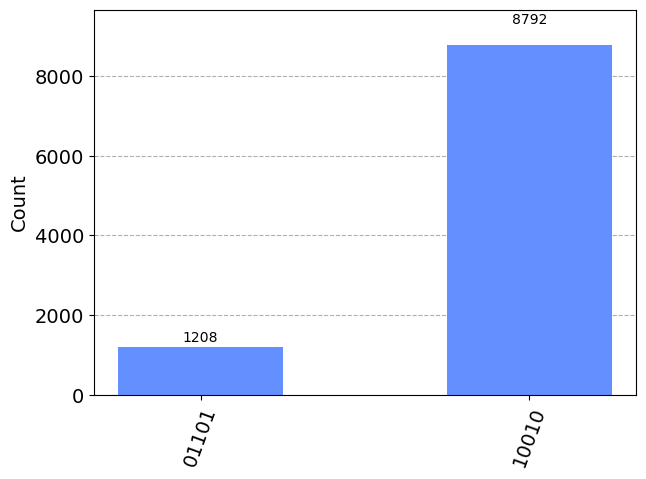

In [6]:
rulestxt = Giaco
nrshots = 10000

singletransitioncircuit = synthesizeFullNetworkUpdateCircuit(rulestxt)
n = int(singletransitioncircuit.num_qubits / 2)
N = 2**n

nrTransitions = 4
total_numbers = (nrTransitions+1)*n
Ttransition = forwardtransitioncircuit(rulestxt, nrTransitions=nrTransitions)

qr = QuantumRegister(Ttransition.num_qubits)
cr = ClassicalRegister(n)
qc = QuantumCircuit(qr, cr)
qc.h(list(range(n)))
qc = qc.compose(Ttransition, qubits=list(range(0,Ttransition.num_qubits)))

qc.measure(qubit=list(range(total_numbers-n, total_numbers)), cbit=list(range(n)))

result = execute(qc, backend=Aer.get_backend('qasm_simulator'), shots=nrshots).result()
countDict = result.get_counts(qc)
print(countDict)
remainingstates = [int(x,2) for x in list(countDict.keys())]
print("remainingstates in CountDict after deletion:")
print(remainingstates)
print(N, n)

plot_histogram(countDict)

In [9]:
rulestxt = n4testnet
nrshots = 10000

singletransitioncircuit = synthesizeFullNetworkUpdateCircuit(rulestxt)
n = int(singletransitioncircuit.num_qubits / 2)
N = 2**n

nrTransitions = 4
total_numbers = (nrTransitions+1)*n
Ttransition = forwardtransitioncircuit(rulestxt, nrTransitions=nrTransitions)

qr = QuantumRegister(Ttransition.num_qubits)
cr = ClassicalRegister(n)
qc = QuantumCircuit(qr, cr)
qc.h(list(range(n)))
qc = qc.compose(Ttransition, qubits=list(range(0,Ttransition.num_qubits)))

qc.measure(qubit=list(range(total_numbers-n, total_numbers)), cbit=list(range(n)))

result = execute(qc, backend=Aer.get_backend('qasm_simulator'), shots=nrshots).result()
countDict = result.get_counts(qc)
print(countDict)
remainingstates = [int(x,2) for x in list(countDict.keys())]
print("remainingstates in CountDict after deletion:")
print(remainingstates)
print(N, n)

#plt.savefig('n4testnet_run1_att.svg', format='svg')

plot_histogram(countDict, filename='n4testnet_run1_att.svg')

{'1100': 1239, '0000': 6892, '1011': 664, '1101': 579, '1111': 626}
remainingstates in CountDict after deletion:
[12, 0, 11, 13, 15]
16 4


# Basin suppressions - n4testnet sequence

In [10]:
#n4testnet: Measure all small basins

rulestxt = n4testnet
nrshots = 10000

singletransitioncircuit = synthesizeFullNetworkUpdateCircuit(rulestxt)
n = int(singletransitioncircuit.num_qubits / 2)
N = 2**n

print("Shot measurement results:")
(circ_suppressed10010_1, j, N, n, Ttransition) = suppression_withBooleanLogic4(rulestxt, attr2mark=["0000"], M=11, nrTransitions=3, totalstates=None)
suppressed10010_1 = QuantumCircuit(circ_suppressed10010_1.num_qubits, n)
suppressed10010_1 = suppressed10010_1.compose(circ_suppressed10010_1, qubits=list(range(0,suppressed10010_1.num_qubits)))
suppressed10010_1.measure(qubit=list(range(n)), cbit=list(range(n)))
result = execute(suppressed10010_1, backend=Aer.get_backend('qasm_simulator'), shots=nrshots).result()
countDict = result.get_counts(suppressed10010_1)
print(countDict)
remainingstates = [int(x,2) for x in list(countDict.keys())]
print("Remaining states after deletion:")
print(remainingstates)
print('Number of "Grover" iterations:',int(j))
print('Total basins size:', N, ', remaining states size:', len(remainingstates))

Shot measurement results:
{'1100': 1993, '1011': 2057, '1101': 2002, '1110': 1958, '1111': 1990}
Remaining states after deletion:
[12, 11, 13, 14, 15]
Number of "Grover" iterations: 1
Total basins size: 16 , remaining states size: 5


In [11]:
#n4testnet: Measure one-sized attractors

rulestxt = n4testnet
nrshots = 10000

singletransitioncircuit = synthesizeFullNetworkUpdateCircuit(rulestxt)
n = int(singletransitioncircuit.num_qubits / 2)
N = 2**n

print("Shot measurement results:")
(circ_suppressed10010_1, j, N, n, Ttransition) = suppression_withBooleanLogic4(rulestxt, attr2mark=["0000",'1100'], M=13, nrTransitions=3, totalstates=None)
suppressed10010_1 = QuantumCircuit(circ_suppressed10010_1.num_qubits, n)
suppressed10010_1 = suppressed10010_1.compose(circ_suppressed10010_1, qubits=list(range(0,suppressed10010_1.num_qubits)))
suppressed10010_1.measure(qubit=list(range(n)), cbit=list(range(n)))
result = execute(suppressed10010_1, backend=Aer.get_backend('qasm_simulator'), shots=nrshots).result()
countDict = result.get_counts(suppressed10010_1)
print(countDict)
remainingstates = [int(x,2) for x in list(countDict.keys())]
print("Remaining states after deletion:")
print(remainingstates)
print('Number of "Grover" iterations:',int(j))
print('Total basins size:', N, ', remaining states size:', len(remainingstates))

Shot measurement results:
{'1011': 3263, '1101': 3399, '1111': 3338}
Remaining states after deletion:
[11, 13, 15]
Number of "Grover" iterations: 2
Total basins size: 16 , remaining states size: 3


In [12]:
#n4testnet: Measure one-sized attractors

rulestxt = n4testnet
nrshots = 10000

singletransitioncircuit = synthesizeFullNetworkUpdateCircuit(rulestxt)
n = int(singletransitioncircuit.num_qubits / 2)
N = 2**n

print("Shot measurement results:")
(circ_suppressed10010_1, j, N, n, Ttransition) = suppression_withBooleanLogic4(rulestxt, attr2mark=["0000",'1100','1011'], M=14, nrTransitions=3, totalstates=None)
suppressed10010_1 = QuantumCircuit(circ_suppressed10010_1.num_qubits, n)
suppressed10010_1 = suppressed10010_1.compose(circ_suppressed10010_1, qubits=list(range(0,suppressed10010_1.num_qubits)))
suppressed10010_1.measure(qubit=list(range(n)), cbit=list(range(n)))
result = execute(suppressed10010_1, backend=Aer.get_backend('qasm_simulator'), shots=nrshots).result()
countDict = result.get_counts(suppressed10010_1)
print(countDict)
remainingstates = [int(x,2) for x in list(countDict.keys())]
print("Remaining states after deletion:")
print(remainingstates)
print('Number of "Grover" iterations:',int(j))
print('Total basins size:', N, ', remaining states size:', len(remainingstates))

Shot measurement results:
{'1101': 4908, '1111': 5092}
Remaining states after deletion:
[13, 15]
Number of "Grover" iterations: 2
Total basins size: 16 , remaining states size: 2


In [13]:
#n4testnet: Measure one-sized attractors

rulestxt = n4testnet
nrshots = 10000

singletransitioncircuit = synthesizeFullNetworkUpdateCircuit(rulestxt)
n = int(singletransitioncircuit.num_qubits / 2)
N = 2**n

print("Shot measurement results:")
(circ_suppressed10010_1, j, N, n, Ttransition) = suppression_withBooleanLogic4(rulestxt, attr2mark=["0000",'1100','1011','1101'], M=15, nrTransitions=3, totalstates=None)
suppressed10010_1 = QuantumCircuit(circ_suppressed10010_1.num_qubits, n)
suppressed10010_1 = suppressed10010_1.compose(circ_suppressed10010_1, qubits=list(range(0,suppressed10010_1.num_qubits)))
suppressed10010_1.measure(qubit=list(range(n)), cbit=list(range(n)))
result = execute(suppressed10010_1, backend=Aer.get_backend('qasm_simulator'), shots=nrshots).result()
countDict = result.get_counts(suppressed10010_1)
print(countDict)
remainingstates = [int(x,2) for x in list(countDict.keys())]
print("Remaining states after deletion:")
print(remainingstates)
print('Number of "Grover" iterations:',int(j))
print('Total basins size:', N, ', remaining states size:', len(remainingstates))

Shot measurement results:
{'1111': 10000}
Remaining states after deletion:
[15]
Number of "Grover" iterations: 3
Total basins size: 16 , remaining states size: 1


# Basin suppressions - Giacomantonio

In [14]:
#Giacomantonio: Measure small basin

rulestxt = Giaco
nrshots = 10000

singletransitioncircuit = synthesizeFullNetworkUpdateCircuit(rulestxt)
n = int(singletransitioncircuit.num_qubits / 2)
N = 2**n

print("Shot measurement results:")
(circ_suppressed10010_1, j, N, n, Ttransition) = suppression_withBooleanLogic4(rulestxt, attr2mark=["10010"], M=28, nrTransitions=4, totalstates=None)
suppressed10010_1 = QuantumCircuit(circ_suppressed10010_1.num_qubits, n)
suppressed10010_1 = suppressed10010_1.compose(circ_suppressed10010_1, qubits=list(range(0,suppressed10010_1.num_qubits)))
suppressed10010_1.measure(qubit=list(range(n)), cbit=list(range(n)))
result = execute(suppressed10010_1, backend=Aer.get_backend('qasm_simulator'), shots=nrshots).result()
countDict = result.get_counts(suppressed10010_1)
print(countDict)
remainingstates = [int(x,2) for x in list(countDict.keys())]
print("Remaining states after deletion:")
print(remainingstates)
print('Number of "Grover" iterations:',int(j))
print('Total basins size:', N, ', remaining states size:', len(remainingstates))

Shot measurement results:
{'01001': 2498, '11101': 2439, '11001': 2553, '01101': 2510}
Remaining states after deletion:
[9, 29, 25, 13]
Number of "Grover" iterations: 2
Total basins size: 32 , remaining states size: 4


In [15]:
#Giacomantonio: Measure small basin

rulestxt = Giaco
nrshots = 10000

singletransitioncircuit = synthesizeFullNetworkUpdateCircuit(rulestxt)
n = int(singletransitioncircuit.num_qubits / 2)
N = 2**n

print("Shot measurement results:")
(circ_suppressed10010_1, j, N, n, Ttransition) = suppression_withBooleanLogic4(rulestxt, attr2mark=["01101"], M=4, nrTransitions=4, totalstates=None)
suppressed10010_1 = QuantumCircuit(circ_suppressed10010_1.num_qubits, n)
suppressed10010_1 = suppressed10010_1.compose(circ_suppressed10010_1, qubits=list(range(0,suppressed10010_1.num_qubits)))
suppressed10010_1.measure(qubit=list(range(n)), cbit=list(range(n)))
result = execute(suppressed10010_1, backend=Aer.get_backend('qasm_simulator'), shots=nrshots).result()
countDict = result.get_counts(suppressed10010_1)
print(countDict)
remainingstates = [int(x,2) for x in list(countDict.keys())]
print("Remaining states after deletion:")
print(remainingstates)
print('Number of "Grover" iterations:',int(j))
print('Total basins size:', N, ', remaining states size:', len(remainingstates))

Shot measurement results:
{'10101': 347, '11110': 362, '00110': 322, '01111': 332, '10000': 356, '01011': 357, '11100': 342, '01000': 348, '10111': 370, '00010': 367, '10110': 349, '11111': 365, '00001': 357, '00111': 377, '00000': 381, '00100': 357, '00101': 363, '10100': 388, '11000': 355, '01110': 325, '10010': 369, '11011': 350, '11010': 370, '01100': 370, '10011': 344, '10001': 348, '01010': 377, '00011': 352}
Remaining states after deletion:
[21, 30, 6, 15, 16, 11, 28, 8, 23, 2, 22, 31, 1, 7, 0, 4, 5, 20, 24, 14, 18, 27, 26, 12, 19, 17, 10, 3]
Number of "Grover" iterations: 1
Total basins size: 32 , remaining states size: 28


# Attractors measurement - n4testnet sequence

In [7]:
#Giacomantonio: Measure small attractor
rulestxt = n4testnet
nrshots = 10000

singletransitioncircuit = synthesizeFullNetworkUpdateCircuit(rulestxt)
n = int(singletransitioncircuit.num_qubits / 2)
N = 2**n

print("Shot measurement results:")
nrTransitions = 3
total_numbers = (nrTransitions+1)*n

(circ_suppressed10010_1, j, N, n, Ttransition) = suppression_withBooleanLogic4(rulestxt, attr2mark=["0000"], M=11, nrTransitions=nrTransitions, totalstates=None)
suppressed10010_1 = QuantumCircuit(circ_suppressed10010_1.num_qubits, n)
suppressed10010_1 = suppressed10010_1.compose(circ_suppressed10010_1, qubits=list(range(0,suppressed10010_1.num_qubits)))
suppressed10010_1 = suppressed10010_1.compose(Ttransition, qubits=list(range(0,suppressed10010_1.num_qubits)))
suppressed10010_1.measure(qubit=list(range(total_numbers-n, total_numbers)), cbit=list(range(n)))
result = execute(suppressed10010_1, backend=Aer.get_backend('qasm_simulator'), shots=nrshots).result()
countDict4_1 = result.get_counts(suppressed10010_1)
print(countDict4_1)
remainingstates = [int(x,2) for x in list(countDict4_1.keys())]
print("Remaining states after deletion:")
print(remainingstates)
print('Number of "Grover" iterations:',int(j))
print('Total basins size:', N, ', remaining states size:', len(remainingstates))

plot_histogram(countDict4_1, filename='n4testnet_run2_att.svg')

Shot measurement results:
{'1111': 1921, '1101': 1985, '1100': 4045, '1011': 2049}
Remaining states after deletion:
[15, 13, 12, 11]
Number of "Grover" iterations: 1
Total basins size: 16 , remaining states size: 4


In [8]:
#Giacomantonio: Measure small attractor
rulestxt = n4testnet
nrshots = 10000

singletransitioncircuit = synthesizeFullNetworkUpdateCircuit(rulestxt)
n = int(singletransitioncircuit.num_qubits / 2)
N = 2**n

print("Shot measurement results:")
nrTransitions = 3
total_numbers = (nrTransitions+1)*n

(circ_suppressed10010_1, j, N, n, Ttransition) = suppression_withBooleanLogic4(rulestxt, attr2mark=["0000",'1101'], M=12, nrTransitions=nrTransitions, totalstates=None)
suppressed10010_1 = QuantumCircuit(circ_suppressed10010_1.num_qubits, n)
suppressed10010_1 = suppressed10010_1.compose(circ_suppressed10010_1, qubits=list(range(0,suppressed10010_1.num_qubits)))
suppressed10010_1 = suppressed10010_1.compose(Ttransition, qubits=list(range(0,suppressed10010_1.num_qubits)))
suppressed10010_1.measure(qubit=list(range(total_numbers-n, total_numbers)), cbit=list(range(n)))
result = execute(suppressed10010_1, backend=Aer.get_backend('qasm_simulator'), shots=nrshots).result()
countDict4_2 = result.get_counts(suppressed10010_1)
print(countDict4_2)
remainingstates = [int(x,2) for x in list(countDict4_2.keys())]
print("Remaining states after deletion:")
print(remainingstates)
print('Number of "Grover" iterations:',int(j))
print('Total basins size:', N, ', remaining states size:', len(remainingstates))
plot_histogram(countDict4_2, filename='n4testnet_run3_att.svg')

Shot measurement results:
{'1011': 2406, '1100': 5091, '1111': 2503}
Remaining states after deletion:
[11, 12, 15]
Number of "Grover" iterations: 1
Total basins size: 16 , remaining states size: 3


In [9]:
#Giacomantonio: Measure small attractor
rulestxt = n4testnet
nrshots = 10000

singletransitioncircuit = synthesizeFullNetworkUpdateCircuit(rulestxt)
n = int(singletransitioncircuit.num_qubits / 2)
N = 2**n

print("Shot measurement results:")
nrTransitions = 3
total_numbers = (nrTransitions+1)*n

(circ_suppressed10010_1, j, N, n, Ttransition) = suppression_withBooleanLogic4(rulestxt, attr2mark=["0000",'1101','1100'], M=14, nrTransitions=nrTransitions, totalstates=None)
suppressed10010_1 = QuantumCircuit(circ_suppressed10010_1.num_qubits, n)
suppressed10010_1 = suppressed10010_1.compose(circ_suppressed10010_1, qubits=list(range(0,suppressed10010_1.num_qubits)))
suppressed10010_1 = suppressed10010_1.compose(Ttransition, qubits=list(range(0,suppressed10010_1.num_qubits)))
suppressed10010_1.measure(qubit=list(range(total_numbers-n, total_numbers)), cbit=list(range(n)))
result = execute(suppressed10010_1, backend=Aer.get_backend('qasm_simulator'), shots=nrshots).result()
countDict4_3 = result.get_counts(suppressed10010_1)
print(countDict4_3)
remainingstates = [int(x,2) for x in list(countDict4_3.keys())]
print("Remaining states after deletion:")
print(remainingstates)
print('Number of "Grover" iterations:',int(j))
print('Total basins size:', N, ', remaining states size:', len(remainingstates))
plot_histogram(countDict4_3, filename='n4testnet_run4_att.svg')

Shot measurement results:
{'1111': 4961, '1011': 5039}
Remaining states after deletion:
[15, 11]
Number of "Grover" iterations: 2
Total basins size: 16 , remaining states size: 2


In [10]:
#Giacomantonio: Measure small attractor
rulestxt = n4testnet
nrshots = 10000

singletransitioncircuit = synthesizeFullNetworkUpdateCircuit(rulestxt)
n = int(singletransitioncircuit.num_qubits / 2)
N = 2**n

print("Shot measurement results:")
nrTransitions = 3
total_numbers = (nrTransitions+1)*n

(circ_suppressed10010_1, j, N, n, Ttransition) = suppression_withBooleanLogic4(rulestxt, attr2mark=["0000",'1101','1100','1111'], M=15, nrTransitions=nrTransitions, totalstates=None)
suppressed10010_1 = QuantumCircuit(circ_suppressed10010_1.num_qubits, n)
suppressed10010_1 = suppressed10010_1.compose(circ_suppressed10010_1, qubits=list(range(0,suppressed10010_1.num_qubits)))
suppressed10010_1 = suppressed10010_1.compose(Ttransition, qubits=list(range(0,suppressed10010_1.num_qubits)))
suppressed10010_1.measure(qubit=list(range(total_numbers-n, total_numbers)), cbit=list(range(n)))
result = execute(suppressed10010_1, backend=Aer.get_backend('qasm_simulator'), shots=nrshots).result()
countDict4_4 = result.get_counts(suppressed10010_1)
print(countDict4_4)
remainingstates = [int(x,2) for x in list(countDict4_4.keys())]
print("Remaining states after deletion:")
print(remainingstates)
print('Number of "Grover" iterations:',int(j))
print('Total basins size:', N, ', remaining states size:', len(remainingstates))
plot_histogram(countDict4_4, filename='n4testnet_run5_att.svg')

Shot measurement results:
{'1011': 10000}
Remaining states after deletion:
[11]
Number of "Grover" iterations: 3
Total basins size: 16 , remaining states size: 1


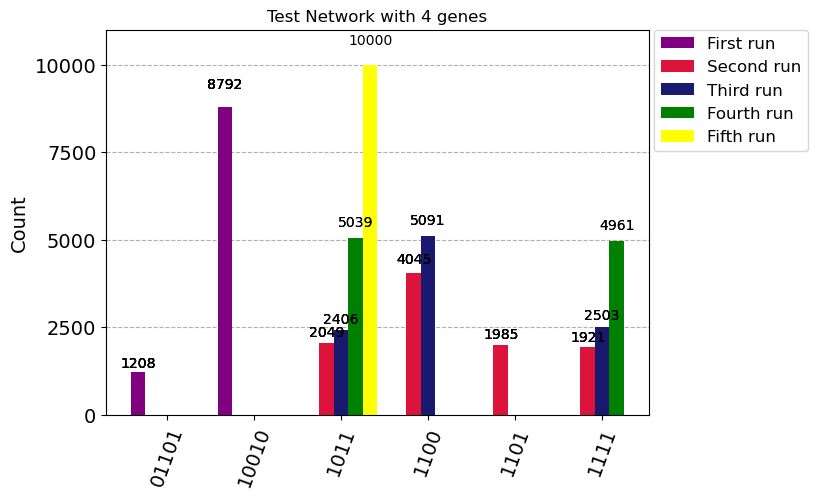

In [11]:
legend = ['First run', 'Second run', 'Third run', 'Fourth run', 'Fifth run']
plot_histogram([countDict, countDict4_1, countDict4_2, countDict4_3, countDict4_4], legend=legend, color=['purple','crimson','midnightblue','green','yellow'],title="Test Network with 4 genes")
#plot_histogram([countDict, countDict4_1, countDict4_2, countDict4_3, countDict4_4], legend=legend, color=['purple','crimson','midnightblue','green','yellow'],title="Test Network with 4 genes", filename='n4testnet_allRun_att.svg')

#0000ffff

# Attractors measurement - Giacomantonio

In [12]:
#Giacomantonio: Measure small attractor
rulestxt = Giaco
nrshots = 10000

print("Shot measurement results:")
nrTransitions = 4
total_numbers = (nrTransitions+1)*n

(circ_suppressed10010_1, j, N, n, Ttransition) = suppression_withBooleanLogic4(rulestxt, attr2mark=["10010"], M=28, nrTransitions=nrTransitions, totalstates=None)
suppressed10010_1 = QuantumCircuit(circ_suppressed10010_1.num_qubits, n)
suppressed10010_1 = suppressed10010_1.compose(circ_suppressed10010_1, qubits=list(range(0,suppressed10010_1.num_qubits)))
suppressed10010_1 = suppressed10010_1.compose(Ttransition, qubits=list(range(0,suppressed10010_1.num_qubits)))
suppressed10010_1.measure(qubit=list(range(total_numbers-n, total_numbers)), cbit=list(range(n)))
result = execute(suppressed10010_1, backend=Aer.get_backend('qasm_simulator'), shots=nrshots).result()
countDict_small = result.get_counts(suppressed10010_1)
print(countDict_small)
remainingstates = [int(x,2) for x in list(countDict_small.keys())]
print("Remaining states after deletion:")
print(remainingstates)
print('Number of "Grover" iterations:',int(j))
print('Total basins size:', N, ', remaining states size:', len(remainingstates))

Shot measurement results:
{'01101': 10000}
Remaining states after deletion:
[13]
Number of "Grover" iterations: 2
Total basins size: 32 , remaining states size: 1


In [13]:
#Giacomantonio: Measure big attractor
rulestxt = Giaco
nrshots = 10000

print("Shot measurement results:")
nrTransitions = 4
total_numbers = (nrTransitions+1)*n

(circ_suppressed10010_1, j, N, n, Ttransition) = suppression_withBooleanLogic4(rulestxt, attr2mark=["01101"], M=4, nrTransitions=nrTransitions, totalstates=None)
suppressed10010_1 = QuantumCircuit(circ_suppressed10010_1.num_qubits, n)
suppressed10010_1 = suppressed10010_1.compose(circ_suppressed10010_1, qubits=list(range(0,suppressed10010_1.num_qubits)))
suppressed10010_1 = suppressed10010_1.compose(Ttransition, qubits=list(range(0,suppressed10010_1.num_qubits)))
suppressed10010_1.measure(qubit=list(range(total_numbers-n, total_numbers)), cbit=list(range(n)))
result = execute(suppressed10010_1, backend=Aer.get_backend('qasm_simulator'), shots=nrshots).result()
countDict_large = result.get_counts(suppressed10010_1)
print(countDict_large)
remainingstates = [int(x,2) for x in list(countDict_large.keys())]
print("Remaining states after deletion:")
print(remainingstates)
print('Number of "Grover" iterations:',int(j))
print('Total basins size:', N, ', remaining states size:', len(remainingstates))

Shot measurement results:
{'10010': 10000}
Remaining states after deletion:
[18]
Number of "Grover" iterations: 1
Total basins size: 32 , remaining states size: 1


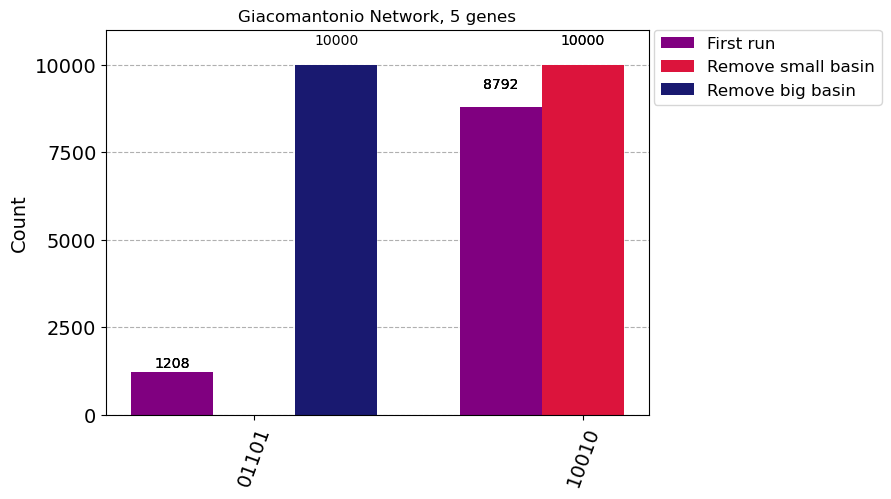

In [15]:
legend = ['First run', 'Remove small basin', 'Remove big basin']
plot_histogram([countDict, countDict_large, countDict_small], legend=legend, color=['purple','crimson','midnightblue'],title="Giacomantonio Network, 5 genes")

In [14]:
#Save the plot as file
legend = ['First run', 'Remove small basin', 'Remove big basin']
plot_histogram([countDict, countDict_large, countDict_small], legend=legend, color=['purple','crimson','midnightblue'],title="Giacomantonio Network, 5 genes", filename='Giacomantonio_allRun_att.svg')

# Noise analysis - n4testnet - attractors measurement

## Circuit creation 

In [16]:
rulestxt = n4testnet
nrshots = 10000

singletransitioncircuit = synthesizeFullNetworkUpdateCircuit(rulestxt)
n = int(singletransitioncircuit.num_qubits / 2)
N = 2**n
nrTransitions = 3
total_numbers = (nrTransitions+1)*n

(circ_suppressed10010_1, j, N, n, Ttransition) = suppression_withBooleanLogic4(rulestxt, attr2mark=["0000"], M=11, nrTransitions=nrTransitions, totalstates=None)
suppressed10010_1 = QuantumCircuit(circ_suppressed10010_1.num_qubits, n)
suppressed10010_1 = suppressed10010_1.compose(circ_suppressed10010_1, qubits=list(range(0,suppressed10010_1.num_qubits)))
suppressed10010_1 = suppressed10010_1.compose(Ttransition, qubits=list(range(0,suppressed10010_1.num_qubits)))
suppressed10010_1.measure(qubit=list(range(total_numbers-n, total_numbers)), cbit=list(range(n)))

(circ_suppressed10010_2, j, N, n, Ttransition) = suppression_withBooleanLogic4(rulestxt, attr2mark=["0000",'1101'], M=12, nrTransitions=nrTransitions, totalstates=None)
suppressed10010_2 = QuantumCircuit(circ_suppressed10010_2.num_qubits, n)
suppressed10010_2 = suppressed10010_2.compose(circ_suppressed10010_2, qubits=list(range(0,suppressed10010_2.num_qubits)))
suppressed10010_2 = suppressed10010_2.compose(Ttransition, qubits=list(range(0,suppressed10010_2.num_qubits)))
suppressed10010_2.measure(qubit=list(range(total_numbers-n, total_numbers)), cbit=list(range(n)))

(circ_suppressed10010_3, j, N, n, Ttransition) = suppression_withBooleanLogic4(rulestxt, attr2mark=["0000",'1101','1100'], M=14, nrTransitions=nrTransitions, totalstates=None)
suppressed10010_3 = QuantumCircuit(circ_suppressed10010_3.num_qubits, n)
suppressed10010_3 = suppressed10010_3.compose(circ_suppressed10010_3, qubits=list(range(0,suppressed10010_3.num_qubits)))
suppressed10010_3 = suppressed10010_3.compose(Ttransition, qubits=list(range(0,suppressed10010_3.num_qubits)))
suppressed10010_3.measure(qubit=list(range(total_numbers-n, total_numbers)), cbit=list(range(n)))

(circ_suppressed10010_4, j, N, n, Ttransition) = suppression_withBooleanLogic4(rulestxt, attr2mark=["0000",'1101','1100','1111'], M=15, nrTransitions=nrTransitions, totalstates=None)
suppressed10010_4 = QuantumCircuit(circ_suppressed10010_4.num_qubits, n)
suppressed10010_4 = suppressed10010_4.compose(circ_suppressed10010_4, qubits=list(range(0,suppressed10010_4.num_qubits)))
suppressed10010_4 = suppressed10010_4.compose(Ttransition, qubits=list(range(0,suppressed10010_4.num_qubits)))
suppressed10010_4.measure(qubit=list(range(total_numbers-n, total_numbers)), cbit=list(range(n)))

## Noisy runs

Time for algorithm:  16.61483097076416 s


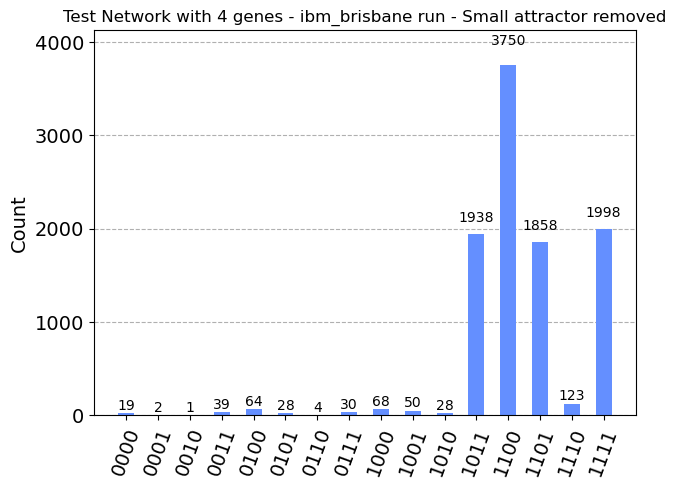

In [24]:
import time

start_time = time.time()

#n4testnet: Measure one-sized attractors

backend = provider.get_backend('ibm_brisbane')
noise_model = NoiseModel.from_backend(backend)

simulator = Aer.get_backend('aer_simulator')
noisy_qc = transpile(suppressed10010_1, simulator)
result = simulator.run(noisy_qc, noise_model=noise_model, shots=10000).result()
counts = result.get_counts()

end_time = time.time()

# Calculate the elapsed time
print('Time for algorithm: ', end_time - start_time, 's')
#print("Shot measurement results:")
plot_histogram(counts,title="Test Network with 4 genes - ibm_brisbane run - Small attractor removed")

In [ ]:
#Save the plot
plot_histogram(counts,title="Test Network with 4 genes - ibm_brisbane run - Small attractor removed", filename='n4testnet_brisbaneSim_1AttRem.svg')

Time for algorithm:  16.82013750076294 s
Shot measurement results:


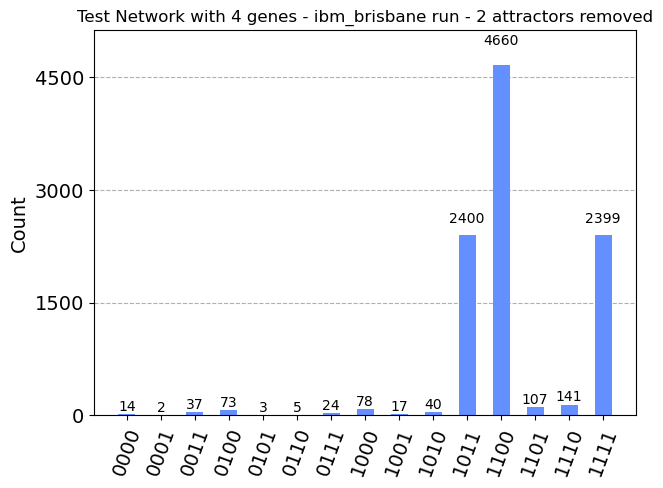

In [25]:
import time

start_time = time.time()

#n4testnet: Measure one-sized attractors

backend = provider.get_backend('ibm_brisbane')
noise_model = NoiseModel.from_backend(backend)

simulator = Aer.get_backend('aer_simulator')
noisy_qc = transpile(suppressed10010_2, simulator)
result = simulator.run(noisy_qc, noise_model=noise_model, shots=10000).result()
counts = result.get_counts()

end_time = time.time()

# Calculate the elapsed time
print('Time for algorithm: ', end_time - start_time, 's')
print("Shot measurement results:")
plot_histogram(counts,title="Test Network with 4 genes - ibm_brisbane run - 2 attractors removed")

In [ ]:
#Save the plot
plot_histogram(counts,title="Test Network with 4 genes - ibm_brisbane run - 2 attractors removed", filename='n4testnet_brisbaneSim_2AttRem.svg')

Time for algorithm:  25.420361518859863 s
Shot measurement results:


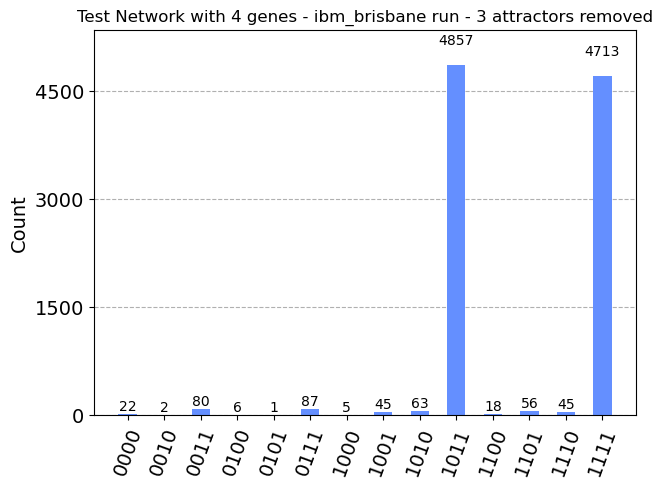

In [27]:
import time

start_time = time.time()

#n4testnet: Measure one-sized attractors

backend = provider.get_backend('ibm_brisbane')
noise_model = NoiseModel.from_backend(backend)

simulator = Aer.get_backend('aer_simulator')
noisy_qc = transpile(suppressed10010_3, simulator)
result = simulator.run(noisy_qc, noise_model=noise_model, shots=10000).result()
counts = result.get_counts()

end_time = time.time()

# Calculate the elapsed time
print('Time for algorithm: ', end_time - start_time, 's')
print("Shot measurement results:")
plot_histogram(counts,title="Test Network with 4 genes - ibm_brisbane run - 3 attractors removed")

In [ ]:
#Save the plot
plot_histogram(counts,title="Test Network with 4 genes - ibm_brisbane run - 3 attractors removed", filename='n4testnet_brisbaneSim_3AttRem.svg')

Time for algorithm:  42.52362680435181 s
Shot measurement results:


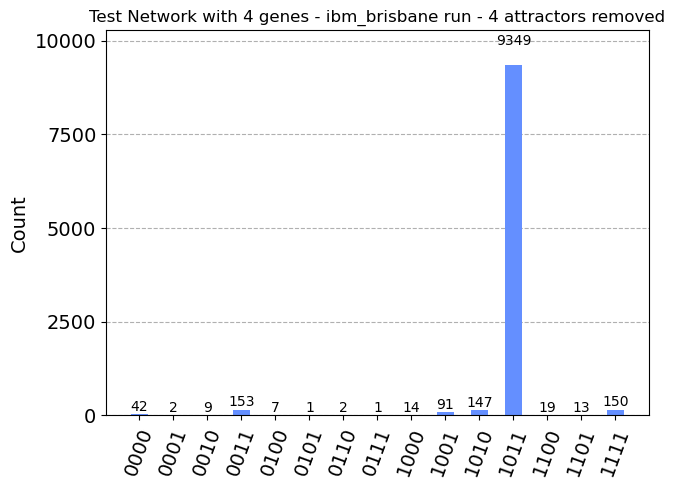

In [28]:
import time

start_time = time.time()

#n4testnet: Measure one-sized attractors

backend = provider.get_backend('ibm_brisbane')
noise_model = NoiseModel.from_backend(backend)

simulator = Aer.get_backend('aer_simulator')
noisy_qc = transpile(suppressed10010_4, simulator)
result = simulator.run(noisy_qc, noise_model=noise_model, shots=10000).result()
counts = result.get_counts()

end_time = time.time()

# Calculate the elapsed time
print('Time for algorithm: ', end_time - start_time, 's')
print("Shot measurement results:")
plot_histogram(counts,title="Test Network with 4 genes - ibm_brisbane run - 4 attractors removed")

In [ ]:
#Save the plot
plot_histogram(counts,title="Test Network with 4 genes - ibm_brisbane run - 4 attractors removed", filename='n4testnet_brisbaneSim_4AttRem.svg')

# Giacomantonio - noise runs

## Circuit creation 

In [180]:
rulestxt = Giaco
nrshots = 10000
singletransitioncircuit = synthesizeFullNetworkUpdateCircuit(rulestxt)
n = int(singletransitioncircuit.num_qubits / 2)
N = 2**n
#print("Shot measurement results:")
nrTransitions = 4
total_numbers = (nrTransitions+1)*n

(circ_suppressed10010_1, j, N, n, Ttransition) = suppression_withBooleanLogic4(rulestxt, attr2mark=["10010"], M=28, nrTransitions=nrTransitions, totalstates=None)
suppressed10010_1 = QuantumCircuit(circ_suppressed10010_1.num_qubits, n)
suppressed10010_1 = suppressed10010_1.compose(circ_suppressed10010_1, qubits=list(range(0,suppressed10010_1.num_qubits)))
suppressed10010_1 = suppressed10010_1.compose(Ttransition, qubits=list(range(0,suppressed10010_1.num_qubits)))
suppressed10010_1.measure(qubit=list(range(total_numbers-n, total_numbers)), cbit=list(range(n)))

(circ_suppressed10010_2, j, N, n, Ttransition) = suppression_withBooleanLogic4(rulestxt, attr2mark=["01101"], M=4, nrTransitions=nrTransitions, totalstates=None)
suppressed10010_2 = QuantumCircuit(circ_suppressed10010_2.num_qubits, n)
suppressed10010_2 = suppressed10010_2.compose(circ_suppressed10010_2, qubits=list(range(0,suppressed10010_2.num_qubits)))
suppressed10010_2 = suppressed10010_2.compose(Ttransition, qubits=list(range(0,suppressed10010_2.num_qubits)))
suppressed10010_2.measure(qubit=list(range(total_numbers-n, total_numbers)), cbit=list(range(n)))

## Noisy runs 

In [181]:
import time

start_time = time.time()

#Giaco: Measure small attractor

backend = provider.get_backend('ibm_brisbane')
noise_model = NoiseModel.from_backend(backend)

simulator = Aer.get_backend('aer_simulator')
noisy_qc = transpile(suppressed10010_1, simulator)
result = simulator.run(noisy_qc, noise_model=noise_model, shots=10000).result()
counts_small = result.get_counts()

end_time = time.time()

# Calculate the elapsed time
print('Time for algorithm: ', end_time - start_time, 's')
#print("Shot measurement results:")
plot_histogram(counts_small)

Time for algorithm:  50337.74597501755 s


In [ ]:
#Save the plot on file
plot_histogram(counts_small, filename='Giacomantonio_bigSuppressNoise_att.svg')

Time for algorithm:  44020.09746050835 s
Shot measurement results:


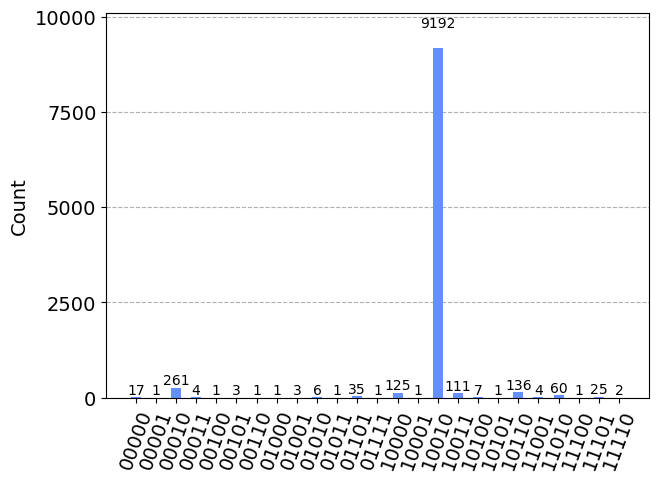

In [160]:
import time

start_time = time.time()

#Giaco: Measure big attractor

backend = provider.get_backend('ibm_brisbane')
noise_model = NoiseModel.from_backend(backend)

simulator = Aer.get_backend('aer_simulator')
noisy_qc = transpile(suppressed10010_2, simulator)
result = simulator.run(noisy_qc, noise_model=noise_model, shots=10000).result()
counts = result.get_counts()

end_time = time.time()

# Calculate the elapsed time
print('Time for algorithm: ', end_time - start_time, 's')
print("Shot measurement results:")
plot_histogram(counts)

In [161]:
plot_histogram(counts, filename='Giacomantonio_smallSuppressNoise_att.svg')